In [46]:
import pandas as pd 
from Response_Spectrum import *
from sympy import symbols, Eq, Function,UnevaluatedExpr, Mul
from sympy import *

#init_printing()
from sympy import Piecewise, nan
import numpy as np

In [47]:
def round_expr(expr, num_digits=2):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

def round_equation(eq, num_digits=2):
    lhs = eq.lhs
    rhs = eq.rhs
    rounded_rhs = round_expr(rhs, num_digits)
    return Eq(lhs, rounded_rhs)

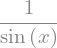

In [48]:
x=symbols('x')
expr=1/sin(x) 
f=lambdify(x, expr) 
display(expr)
f(2)


In [49]:
RS_params=AASHTO(T=1, PGA=0.4,S_S=0.75,S_1=0.2,SiteClass="B")
# Convert the first element of the array to a numpy number
#RS_params[0].item()
RS_params


(array([0.2]), array(1.), array(1.), array(1.), 0.4, 0.75, 0.2)

In [397]:
def Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1, epsilon,d):
    
    """
    m: Number of supports
    
    n: Number of girders per support
    
    n_c=[0,3,3,0]: Number of columns per support
    ** abutment1, 2 there are no columns
        number of columns = 3 in each pie 1 and 2 
        
    
    W_SS: Weight of superstructure including railings, curbs,and barriers to the permanent loads
    
    W_PP: Weight of piers participating with superstructure in dynamic response
    
    W_eff= W_SS + W_PP: Effective weight
    
    W=[W_1,W_2,...,W_m]: Weight of superstructure at each support
    
    K_sub=[K_sub_abut1, K_sub_pie1, K_sub_pie2, K_sub_abut2]: Stiffness of each support in both longitudinal and transverse directions of the bridge
    ** For the abutments, take Ksub,j to be a large number, say 10,000 kips/in.
    
    angle_skew: Angle of skew
    
    PGA,S_1, S_S: Acceleration coefficients for bridge site are given in design statement
    
    SiteClass:  "A", "B", "C","D","E"
    
    epsilon: tolerance
    
    d: set initial guess for the first iteration
 
    """
    
    
  
    
 
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # B2.1.1—Step A: Identifty Bridge Data
    ## B2.1.1.2—Step A2: Seismic Hazard
    
    ### RS_params: C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1
    #T_eff=1.0 # Set initial period 
    #C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=ASSHTO(T=T_eff, PGA=PGA,S_S=S_S,S_1=S_1,SiteClass=SiteClass) # g=C_sm???
    
    # B2.1.2—STEP B: ANALYZE BRIDGE FOR EARTHQUAKE LOADING IN LONGITUDINAL DIRECTION
    ## B2.1.2.1—STEP B1: SIMPLIFIED METHOD
    ### B2.1.2.1.1—Step B1.1: Initial System Displacement and Properties
        
    #%% Assume that the initial value of displacement d approximates 2.0
    #d=2.0
    i_count=1
  
    while True:
        
        print(f'iteration:{i_count} ')
        print(f'd={d}')
        
        #%% Calculate characteristic strength, Q_d
        Q_d=0.05*W_SS

        #%% Calculate Post-yield stiffness, K_d
        K_d=0.05*(W_SS/d)

        ### B2.1.2.1.2—Step B1.2: Initial Isolator Properties at Supports

        #%% Calculate the characteristic strength, Q_dj

        Q_dj=[Q_d*(W[j]/W_SS) for j in range(m)]

        #%% Calculate postelastic stiffness, K_dj

        K_dj= [K_d*(W[j]/W_SS) for j in range(m)]

       

        ### B2.1.2.1.3—Step B1.3: Effective Stiffness of Combined Pier and Isolator System

        #%% Calculate alpha_j

        alpha_j = [(K_dj[j]*d+Q_dj[j])/(K_sub[j]*d-Q_dj[j]) for j in range(m)]

        #%% Calculate the effective stiffness, K_effj

        K_effj=[(alpha_j[j]*K_sub[j])/(1+alpha_j[j]) for j in range(m)]

        ### B2.1.2.1.4—Step B1.4: Total Effective Stiffness

        #%% Calculate the total effective stiffness, Keff, of the bridge:

        K_eff= sum(K_effj)
        print(f'K_eff: {K_eff}')

        ### B2.1.2.1.5—Step B1.5: Isolation System Displacement at Each Suppor

        #%% Calculate the displacement of the isolation system, d_isolj

        d_isolj=  [d/(1+ alpha_j[j]) for j in range(m)]
        
        print(f'd_isolj: {d_isolj}')

        ### B2.1.2.1.6—Step B1.6: Isolation System Stiffness at Each Support

        #%% Calculate the effective stiffness of the isolation system at support “j”, Kisol,j, for all supports

        K_isolj=[Q_dj[j]/d_isolj[j]+ K_dj[j] for j in range(m)]

        ### 2.1.2.1.7—Step B1.7: Substructure Displacement at Each Support, d_subj

        d_subj= [d- d_isolj[j] for j in range(m)]

        ### B2.1.2.1.8—Step B1.8: Lateral Load in Each Substructure Support

        #%% Calculate the shear at support “j”, Fsub,j, for all supports:

        F_subj= [K_sub[j]* d_subj[j] for j in range(m)]

        ### B2.1.2.1.9—Step B1.9: Column Shear Force at Each Support

        F_coljk=[]

        for j in range(m):
            if n_c[j]==0:
                val=0
            else:
                val= [F_subj[j]/n_c[j]]

            F_coljk.append(val)

        ### B2.1.2.1.10—Step B1.10: Effective Period and Damping Ratio

        #%% Calculate the effective period, T_eff 

        W_eff= W_SS + W_PP #  Effective weight, W_eff
        g=386.4 # (in./s^2) or 9.815(m/s^2)

        T_eff=2*np.pi* (W_eff/(g*K_eff))**(1/2)
        print(f'T_eff: {T_eff}')

        #%% Calculate the viscous damping ratio, ξ , of the bridge

        d_yj=[0]*m # taking d_yj=0

        numerator=2*sum([Q_dj[j]*(d_isolj[j]-d_yj[j]) for j in range(m)])

        denominator=np.pi*sum([K_effj[j]*(d_isolj[j]+d_subj[j])**2 for j in range(m)])

        xi= numerator/denominator

        ### B2.1.2.1.11—Step B1.11: Damping Factor

        #%% Calculate the damping factor, B_L

        B_L=Piecewise(((xi/0.05)**0.03,xi<0.3),(1.7, xi>=0.3))

        #%%  Calculate the displacement, d_new

        d_new=(9.79*S_D1*T_eff)/B_L
        
        print(f'd_new: {d_new}')

        #%%%%%%%%%%%%%%%%%%%%%
        #%% Calculate the diference, abs(d_new-d) 

        difference=abs(d_new-d)

        #%% Check the condition:

        if difference> epsilon:
            d=d_new
            i_count=i_count+1

        else:
            break
      
        
    df = pd.DataFrame({"Pier": ["Abut1", "Pier1", "Pier2", "Abut2"],
                       "$$W_j$$": W,"$$Q_{d,j}$$":Q_dj, "$$K_{d,j}$$":K_dj,
                       "$$K_{sub,j}$$": K_sub,"$\\alpha_j$": alpha_j,
                       "$$F_{sub,j}$$":F_subj , "$$T_{eff}$$": T_eff})
    df = df.round(2)
    
        
    #return print(f'Number of iteration: {i_count}\n Expected structure displacement: {d_new}\n Wj: {W}\nK_dj:{K_dj}\nK_subj:{K_sub}\nQ_dj: {Q_dj}\nalpha_j:{alpha_j}\nK_effj:{K_effj}\n d_isolj: {d_isolj}\n K_isolj:{K_isolj}\n d_subj:{d_subj}'),
     
         
    #return print(f'Number of iteration: {i_count}\n'),print(f'Expected structure displacement: {d_new}\n Wj: {W}\nK_dj:{K_dj}\nK_subj:{K_sub}\nQ_dj: {Q_dj}\nalpha_j:{alpha_j}\nK_effj:{K_effj}\n d_isolj: {d_isolj}\n K_isolj:{K_isolj}\n d_subj:{d_subj}'),
    
    #return print(f'Number of iteration: {i_count}\n'),print(f'Expected structure displacement: {d_new} \n T_eff: {T_eff}')#\n Wj: {W}\nK_dj:{K_dj}\nK_subj:{K_sub}\nQ_dj: {Q_dj}\nalpha_j:{alpha_j}\nK_effj:{K_effj}\n d_isolj: {d_isolj}\n K_isolj:{K_isolj}\n d_subj:{d_subj}'),
    return df
  
          
    

In [398]:
# Example 1.0:
m=4
n=6
n_c=[0,3,3,0]
W_SS=650.52
W_PP=107.16
W=[44.95,280.31,280.31,44.95]
K_sub=[10000,172.0, 172.0,10000]
angle_skew=0


PGA=0.40
S_1=0.20
S_S=0.75
SiteClass="B"




In [399]:
### Calculate Response Spectrum Parameters: C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1
C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=AASHTO(T=1, PGA=PGA,S_S=S_S,S_1=S_1,SiteClass=SiteClass) 

print(f'C_sm={C_sm}')
print(f'F_pga={F_pga}')
print(f'F_a={F_a}')
print(f'F_v={F_v}')
print(f'A_S={A_S}')
print(f'S_DS={S_DS}')
print(f'S_D1={S_D1}')

C_sm=[0.2]
F_pga=1.0
F_a=1.0
F_v=1.0
A_S=0.4
S_DS=0.75
S_D1=0.2


In [400]:
epsilon=0.05
d=1.81
Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1, epsilon,d)

iteration:1 
d=1.81
K_eff: 34.60537283889139
d_isolj: [1.8095505558080567, 1.654049880815343, 1.654049880815343, 1.8095505558080567]
T_eff: 1.4956585395182889
d_new: 1.72264671786871
iteration:2 
d=1.72264671786871
K_eff: 36.2922526976581
d_isolj: [1.72219727650636, 1.56703653546587, 1.56703653546587, 1.72219727650636]
T_eff: 1.46048552908805
d_new: 1.68213568585553


,Pier,$$W_j$$,"$$Q_{d,j}$$","$$K_{d,j}$$","$$K_{sub,j}$$",$\alpha_j$,"$$F_{sub,j}$$",$$T_{eff}$$
0,Abut1,44.95,2.25,1.30467842111042,10000.0,0.000260969732379924,4.49441362355252,1.46048552908805
1,Pier1,280.31,14.02,8.13602687923164,172.0,0.0993022044355699,26.7649513732884,1.46048552908805
2,Pier2,280.31,14.02,8.13602687923164,172.0,0.0993022044355699,26.7649513732884,1.46048552908805
3,Abut2,44.95,2.25,1.30467842111042,10000.0,0.000260969732379924,4.49441362355252,1.46048552908805


In [404]:
epsilon=0.0001
d=1
df=Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1, epsilon,d)
df=df.applymap(lambda x: round(x, 2) if pd.notnull(x) and isinstance(x, (int, float)) else x)
    
df.head()

iteration:1 
d=1
K_eff: 60.82593969142006
d_isolj: [0.9995506010024248, 0.849308256570017, 0.849308256570017, 0.9995506010024248]
T_eff: 1.1281317127422885
d_new: 2.09408492893486
iteration:2 
d=2.09408492893486
K_eff: 30.0614581885637
d_isolj: [2.09363547717278, 1.93721803564211, 1.93721803564211, 2.09363547717278]
T_eff: 1.60471975761858
d_new: 1.84825957965716
iteration:3 
d=1.84825957965716
K_eff: 33.9149501192669
d_isolj: [1.84781013431011, 1.69217026421947, 1.69217026421947, 1.84781013431011]
T_eff: 1.51080575317222
d_new: 1.74009274394777
iteration:4 
d=1.74009274394777
K_eff: 35.9423329219332
d_isolj: [1.73964330199760, 1.58441206454516, 1.58441206454516, 1.73964330199760]
T_eff: 1.46757765271562
d_new: 1.69030414353951
iteration:5 
d=1.69030414353951
K_eff: 36.9593167155535
d_isolj: [1.68985470329899, 1.53482832558528, 1.53482832558528, 1.68985470329899]
T_eff: 1.44724565534387
d_new: 1.66688646656665
iteration:6 
d=1.66688646656665
K_eff: 37.4578213185611
d_isolj: [1.66643702

,Pier,$$W_j$$,"$$Q_{d,j}$$","$$K_{d,j}$$","$$K_{sub,j}$$",$\alpha_j$,"$$F_{sub,j}$$",$$T_{eff}$$
0,Abut1,44.95,2.25,1.36569854126275,10000.0,0.000273177015997776,4.49438620233389,1.42877567403009
1,Pier1,280.31,14.02,8.51655079202139,172.0,0.104188538145986,26.7085315936200,1.42877567403009
2,Pier2,280.31,14.02,8.51655079202139,172.0,0.104188538145986,26.7085315936200,1.42877567403009
3,Abut2,44.95,2.25,1.36569854126275,10000.0,0.000273177015997776,4.49438620233389,1.42877567403009
